In [1]:
import plumed
import matplotlib.pyplot as plt
import os
import subprocess

In [2]:
import MDAnalysis

In [3]:
import numpy as np
import math

In [4]:
ls

001/  066/                      fes_142.dat  fes_61.dat
002/  067/                      fes_143.dat  fes_62.dat
003/  068/                      fes_144.dat  fes_63.dat
004/  069/                      fes_145.dat  fes_64.dat
005/  070/                      fes_146.dat  fes_65.dat
006/  071/                      fes_147.dat  fes_66.dat
007/  072/                      fes_148.dat  fes_67.dat
008/  073/                      fes_149.dat  fes_68.dat
009/  074/                      fes_14.dat   fes_69.dat
010/  075/                      fes_150.dat  fes_6.dat
011/  076/                      fes_151.dat  fes_70.dat
012/  077/                      fes_152.dat  fes_71.dat
013/  align.sh*                 fes_153.dat  fes_72.dat
014/  analisi.trimer.b16.ipynb  fes_154.dat  fes_73.dat
015/  cat2xtc.tcl*              fes_15.dat   fes_74.dat
016/  COLVAR_reweighted         fes_16.dat   fes_75.dat
017/  COLVAR_reweighted1.0-2.0  fes_17.dat   fes_76.dat
018/  COLVAR_reweighted2.0-3.0  fes_18.dat   fes_

In [5]:
miadir=os.getcwd()

In [6]:
print (miadir)

/hdnas/marcol/tau/polimeri-120/trimer/meta/select-new


In [7]:
%%bash
pwd

/hdnas/marcol/tau/polimeri-120/trimer/meta/select-new


In [8]:
!pwd

/hdnas/marcol/tau/polimeri-120/trimer/meta/select-new


In [9]:
%%bash
plumed sum_hills --hills HILLS --stride 20000 --mintozero

PLUMED: PLUMED is starting
PLUMED: Version: 2.9.0 (git: Unknown) compiled on Jun 18 2023 at 17:13:44
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /opt/plumed-2.9.0/lib/plumed
PLUMED: For installed feature, see /opt/plumed-2.9.0/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished setup
PLUMED: Action FAKE
PLUMED:   with label

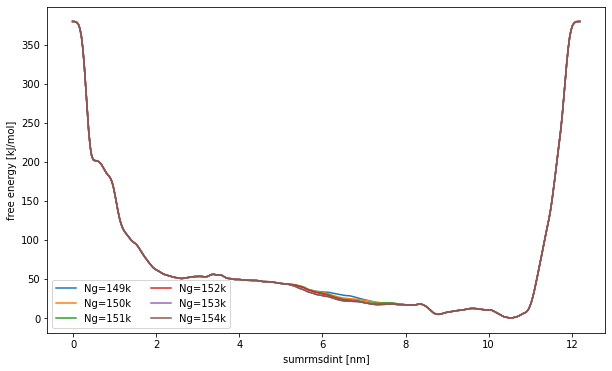

In [5]:
plt.figure(figsize=(10,6))
for i in range(149,155,1):

    data=plumed.read_as_pandas("fes_"+str(i)+".dat")
    plt.plot(data["sumrmsdint"],data["file.free"], label="Ng="+str(int(i/1))+"k")

plt.xlabel("sumrmsdint [nm]")
plt.ylabel("free energy [kJ/mol]")
plt.legend(ncol=2)

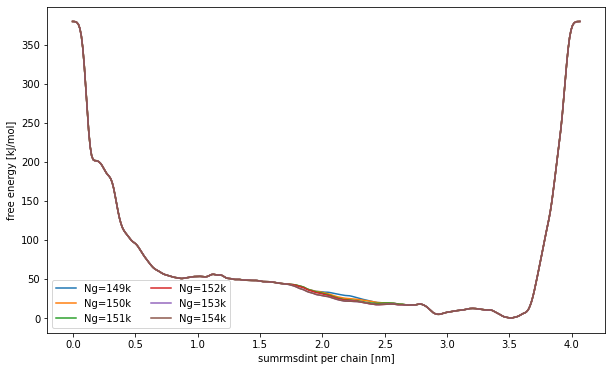

In [6]:
plt.figure(figsize=(10,6))
for i in range(149,155,1):

    data=plumed.read_as_pandas("fes_"+str(i)+".dat")
    plt.plot(data["sumrmsdint"]/3,data["file.free"], label="Ng="+str(int(i/1))+"k")

plt.xlabel("sumrmsdint per chain [nm]")
plt.ylabel("free energy [kJ/mol]")
plt.legend(ncol=2)

In [10]:
data_hills=plumed.read_as_pandas("HILLS")


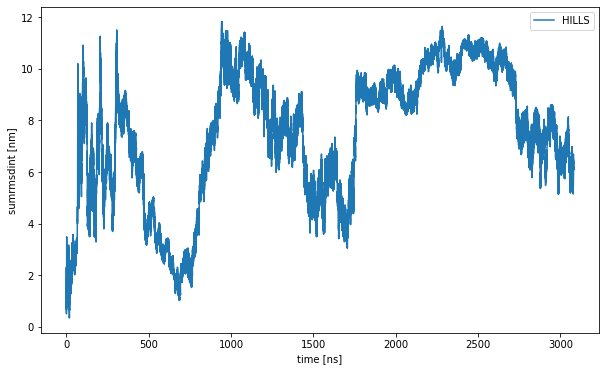

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel("time [ns]")
plt.ylabel("sumrmsdint [nm]")
plt.plot(data_hills["time"]/1000.0,data_hills["sumrmsdint"],label="HILLS")
plt.legend()

In [13]:
%%bash
cat > "plumed_rew.dat" << EOF
rmsda: RMSD REFERENCE=prot_ref_a.pdb TYPE=OPTIMAL
rmsdb: RMSD REFERENCE=prot_ref_b.pdb TYPE=OPTIMAL
rmsdc: RMSD REFERENCE=prot_ref_c.pdb TYPE=OPTIMAL
sumrmsdint: CUSTOM ARG=rmsda,rmsdb,rmsdc VAR=ax,bx,cx FUNC=sqrt(ax*ax+bx*bx+cx*cx) PERIODIC=NO

metad: METAD ARG=sumrmsdint ...
PACE=10000000 HEIGHT=0.0 SIGMA=0.1 FILE=HILLS GRID_MIN=0.0 GRID_MAX=17.0 BIASFACTOR=16.0 TEMP=310.0
RESTART=YES # <- this is the new stuff!
...

# Use the metadynamics bias as argument
as: REWEIGHT_BIAS ARG=metad.bias
# Calculate histograms of phi and psi dihedrals every 50 steps
# using the weights obtained from the metadynamics bias potentials (umbrella-sampling-like reweighting)
# Look at the manual to understand the parameters of the HISTOGRAM action!
hhrmsda: HISTOGRAM ARG=sumrmsdint STRIDE=1 GRID_MIN=0.0 GRID_MAX=17.0 GRID_BIN=170 BANDWIDTH=0.1 LOGWEIGHTS=as
# Convert histograms h(s) to free energies F(s) = -kBT * log(h(s))
ffrmsda: CONVERT_TO_FES GRID=hhrmsda
# Print out the free energies F(s) to file once the entire trajectory is processed
DUMPGRID GRID=ffrmsda FILE=ffrmsda_reweighted.dat

PRINT ARG=sumrmsdint,metad.bias FILE=COLVAR_reweighted STRIDE=1 # <- also change this one!
EOF

In [14]:
'''
plumed driver --ixtc traj_comp_align.xtc --plumed plumed_rew.dat --kt 2.57748341158 --timestep 10.0
'''

'\nplumed driver --ixtc traj_comp_align.xtc --plumed plumed_rew.dat --kt 2.57748341158 --timestep 10.0\n'

In [15]:
%%bash
plumed driver --ixtc traj_comp_align.xtc --plumed plumed_rew.dat --kt 2.57748341158 --timestep 10.0

PLUMED: PLUMED is starting
PLUMED: Version: 2.9.0 (git: Unknown) compiled on Jun 18 2023 at 17:13:44
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /opt/plumed-2.9.0/lib/plumed
PLUMED: For installed feature, see /opt/plumed-2.9.0/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 3591
PLUMED: File suffix: 
PLUMED: FILE: plumed_rew.dat
PLUMED: Action RMSD
PLUMED:   with label rmsda
PLUMED:   reference from file prot_ref_a.pdb
PLUMED:   which contains 307 atoms
PLUMED:   with indices : 
PLUMED: 1 5 8 9 10 12 19 20 21 23 35 36 37 39 52 53 54 56 71 72 73 75 87 88 89 
PLUMED: 91 108 109 110 112 130 131 132 136 144 145 146 148 160 161 162 164 172 173 174 176 191 192 193 195 
PLUMED: 202 203 204 206 224 225 226 228 240 241 242

In [16]:
data_colvar_rew=plumed.read_as_pandas("COLVAR_reweighted")

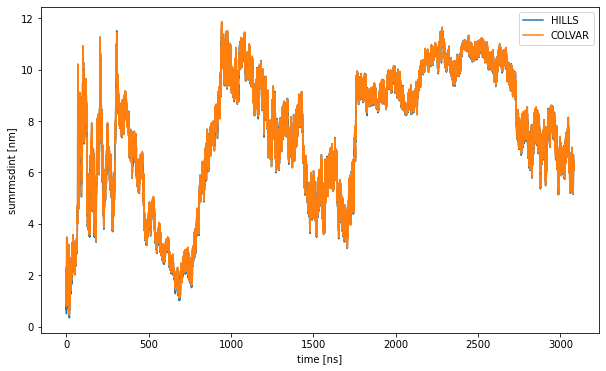

In [17]:
plt.figure(figsize=(10,6))
plt.xlabel("time [ns]")
plt.ylabel("sumrmsdint [nm]")
plt.plot(data_hills["time"]/1000.0,data_hills["sumrmsdint"],label="HILLS")
plt.plot(data_colvar_rew["time"]/1000.0,data_colvar_rew["sumrmsdint"],label="COLVAR")
plt.legend()

In [7]:
data_b=plumed.read_as_pandas("fes_154.dat")
data_r=plumed.read_as_pandas("ffrmsda_reweighted.dat")


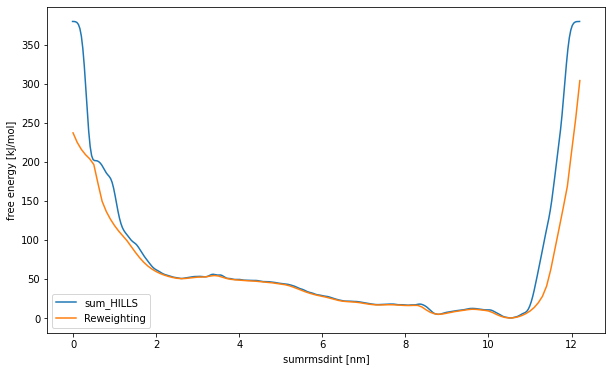

In [8]:
plt.figure(figsize=(10,6))
plt.xlabel("sumrmsdint [nm]")
plt.ylabel("free energy [kJ/mol]")
plt.plot(data_b["sumrmsdint"],data_b["file.free"], label="sum_HILLS")
plt.plot(data_r["sumrmsdint"],data_r["ffrmsda"]-min(data_r["ffrmsda"]),label="Reweighting")
plt.legend()

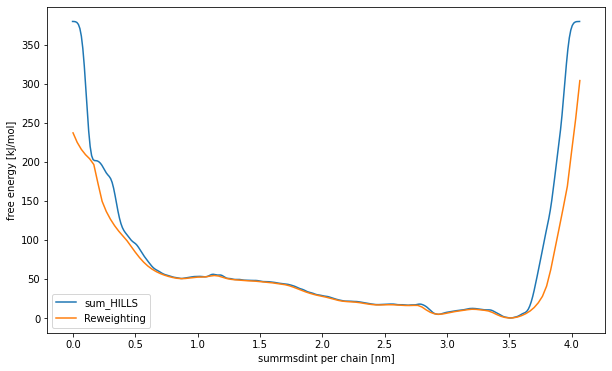

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel("sumrmsdint per chain [nm]")
plt.ylabel("free energy [kJ/mol]")
plt.plot(data_b["sumrmsdint"]/3,data_b["file.free"], label="sum_HILLS")
plt.plot(data_r["sumrmsdint"]/3,data_r["ffrmsda"]-min(data_r["ffrmsda"]),label="Reweighting")
plt.legend()

In [20]:
'''
%%bash
gmx trjcat -f traj_comp_align.xtc -o traj1.0-2.0.xtc -b 1000000 -e 2000000 -dt 10.0
gmx trjcat -f traj_comp_align.xtc -o traj2.0-3.0.xtc -b 2000000 -e 3000000 -dt 10.0
'''

'\n%%bash\ngmx trjcat -f traj_comp_align.xtc -o traj1.0-2.0.xtc -b 1000000 -e 2000000 -dt 10.0\ngmx trjcat -f traj_comp_align.xtc -o traj2.0-3.0.xtc -b 2000000 -e 3000000 -dt 10.0\n'

In [21]:
%%bash
gmx trjcat -f traj_comp_align.xtc -o traj1.0-2.0.xtc -b 1000000 -e 2000000 -dt 10.0
gmx trjcat -f traj_comp_align.xtc -o traj2.0-3.0.xtc -b 2000000 -e 3000000 -dt 10.0

Note that major changes are planned in future for trjcat, to improve usability and utility.
lasttime 0
Note that major changes are planned in future for trjcat, to improve usability and utility.
lasttime 0


               :-) GROMACS - gmx trjcat, 2022.5-plumed_2.9.0 (-:

Executable:   /opt/gromacs-2022.5/bin/gmx_mpi
Data prefix:  /opt/gromacs-2022.5
Working dir:  /hdnas/marcol/tau/polimeri-120/trimer/meta/select-new
Command line:
  gmx trjcat -f traj_comp_align.xtc -o traj1.0-2.0.xtc -b 1000000 -e 2000000 -dt 10.0

Reading frame       1 time   10.000   

Summary of files and start times used:

          File                Start time       Time step
---------------------------------------------------------
      traj_comp_align.xtc        0.000 ps       10.000 ps

Reading frame  100000 time 1000000.000   
Continue writing frames from traj_comp_align.xtc t=1e+06 ps, frame=0      
Reading frame  200000 time 2000000.000    ->  frame 100000 time 2000000.000 ps     
Last frame written was 100000, time 2000000.000000 ps

GROMACS reminds you: "Raw data is like raw sewage, it requires some processing before it can be spread around. The opposite is true of theories." (Jim Carr)

               :-

In [22]:
p=plumed.Plumed()

In [23]:
myhills=plumed.read_as_pandas("HILLS") # first read hills file

In [24]:
plumed.hills_time_average(myhills,"HILLS1.0-2.0",t0=1000000,t1=2000000) # time average between 1000 and 2000 ns

In [25]:
plumed.hills_time_average(myhills,"HILLS2.0-3.0",t0=2000000,t1=3000000) # time average between 2000 and 3000 ns

In [26]:
%%bash
cat > "plumed_rew1.0-2.0.dat" << EOF
rmsda: RMSD REFERENCE=prot_ref_a.pdb TYPE=OPTIMAL
rmsdb: RMSD REFERENCE=prot_ref_b.pdb TYPE=OPTIMAL
rmsdc: RMSD REFERENCE=prot_ref_c.pdb TYPE=OPTIMAL
sumrmsdint: CUSTOM ARG=rmsda,rmsdb,rmsdc VAR=ax,bx,cx FUNC=sqrt(ax*ax+bx*bx+cx*cx) PERIODIC=NO

metad: METAD ARG=sumrmsdint ...
PACE=10000000 HEIGHT=0.0 SIGMA=0.1 FILE=HILLS1.0-2.0 GRID_MIN=0.0 GRID_MAX=17.0 BIASFACTOR=16.0 TEMP=310.0
RESTART=YES # <- this is the new stuff!
...

# Use the metadynamics bias as argument
as: REWEIGHT_BIAS ARG=metad.bias
# Calculate histograms of phi and psi dihedrals every 50 steps
# using the weights obtained from the metadynamics bias potentials (umbrella-sampling-like reweighting)
# Look at the manual to understand the parameters of the HISTOGRAM action!
hhrmsda: HISTOGRAM ARG=sumrmsdint STRIDE=1 GRID_MIN=0.0 GRID_MAX=17.0 GRID_BIN=170 BANDWIDTH=0.1 LOGWEIGHTS=as
# Convert histograms h(s) to free energies F(s) = -kBT * log(h(s))
ffrmsda: CONVERT_TO_FES GRID=hhrmsda
# Print out the free energies F(s) to file once the entire trajectory is processed
DUMPGRID GRID=ffrmsda FILE=ffrmsda_reweighted1.0-2.0.dat

PRINT ARG=sumrmsdint,metad.bias FILE=COLVAR_reweighted1.0-2.0 STRIDE=1 # <- also change this one!

EOF

In [27]:
'''
plumed driver --ixtc traj1.0-2.0.xtc --plumed plumed_rew1.0-2.0.dat --kt 2.57748341158 --timestep 10.0
'''

'\nplumed driver --ixtc traj1.0-2.0.xtc --plumed plumed_rew1.0-2.0.dat --kt 2.57748341158 --timestep 10.0\n'

In [28]:
%%bash
plumed driver --ixtc traj1.0-2.0.xtc --plumed plumed_rew1.0-2.0.dat --kt 2.57748341158 --timestep 10.0

PLUMED: PLUMED is starting
PLUMED: Version: 2.9.0 (git: Unknown) compiled on Jun 18 2023 at 17:13:44
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /opt/plumed-2.9.0/lib/plumed
PLUMED: For installed feature, see /opt/plumed-2.9.0/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 3591
PLUMED: File suffix: 
PLUMED: FILE: plumed_rew1.0-2.0.dat
PLUMED: Action RMSD
PLUMED:   with label rmsda
PLUMED:   reference from file prot_ref_a.pdb
PLUMED:   which contains 307 atoms
PLUMED:   with indices : 
PLUMED: 1 5 8 9 10 12 19 20 21 23 35 36 37 39 52 53 54 56 71 72 73 75 87 88 89 
PLUMED: 91 108 109 110 112 130 131 132 136 144 145 146 148 160 161 162 164 172 173 174 176 191 192 193 195 
PLUMED: 202 203 204 206 224 225 226 228 240 

In [29]:
%%bash
cat > "plumed_rew2.0-3.0.dat" << EOF
rmsda: RMSD REFERENCE=prot_ref_a.pdb TYPE=OPTIMAL
rmsdb: RMSD REFERENCE=prot_ref_b.pdb TYPE=OPTIMAL
rmsdc: RMSD REFERENCE=prot_ref_c.pdb TYPE=OPTIMAL
sumrmsdint: CUSTOM ARG=rmsda,rmsdb,rmsdc VAR=ax,bx,cx FUNC=sqrt(ax*ax+bx*bx+cx*cx) PERIODIC=NO

metad: METAD ARG=sumrmsdint ...
PACE=10000000 HEIGHT=0.0 SIGMA=0.1 FILE=HILLS2.0-3.0 GRID_MIN=0.0 GRID_MAX=17.0 BIASFACTOR=16.0 TEMP=310.0
RESTART=YES # <- this is the new stuff!
...

# Use the metadynamics bias as argument
as: REWEIGHT_BIAS ARG=metad.bias
# Calculate histograms of phi and psi dihedrals every 50 steps
# using the weights obtained from the metadynamics bias potentials (umbrella-sampling-like reweighting)
# Look at the manual to understand the parameters of the HISTOGRAM action!
hhrmsda: HISTOGRAM ARG=sumrmsdint STRIDE=1 GRID_MIN=0.0 GRID_MAX=17.0 GRID_BIN=170 BANDWIDTH=0.1 LOGWEIGHTS=as
# Convert histograms h(s) to free energies F(s) = -kBT * log(h(s))
ffrmsda: CONVERT_TO_FES GRID=hhrmsda
# Print out the free energies F(s) to file once the entire trajectory is processed
DUMPGRID GRID=ffrmsda FILE=ffrmsda_reweighted2.0-3.0.dat

PRINT ARG=sumrmsdint,metad.bias FILE=COLVAR_reweighted2.0-3.0 STRIDE=1 # <- also change this one!

EOF

In [30]:
'''
plumed driver --ixtc traj2.0-3.0.xtc --plumed plumed_rew2.0-3.0.dat --kt 2.57748341158 --timestep 10.0
'''

'\nplumed driver --ixtc traj2.0-3.0.xtc --plumed plumed_rew2.0-3.0.dat --kt 2.57748341158 --timestep 10.0\n'

In [31]:
%%bash
plumed driver --ixtc traj2.0-3.0.xtc --plumed plumed_rew2.0-3.0.dat --kt 2.57748341158 --timestep 10.0

PLUMED: PLUMED is starting
PLUMED: Version: 2.9.0 (git: Unknown) compiled on Jun 18 2023 at 17:13:44
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /opt/plumed-2.9.0/lib/plumed
PLUMED: For installed feature, see /opt/plumed-2.9.0/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 3591
PLUMED: File suffix: 
PLUMED: FILE: plumed_rew2.0-3.0.dat
PLUMED: Action RMSD
PLUMED:   with label rmsda
PLUMED:   reference from file prot_ref_a.pdb
PLUMED:   which contains 307 atoms
PLUMED:   with indices : 
PLUMED: 1 5 8 9 10 12 19 20 21 23 35 36 37 39 52 53 54 56 71 72 73 75 87 88 89 
PLUMED: 91 108 109 110 112 130 131 132 136 144 145 146 148 160 161 162 164 172 173 174 176 191 192 193 195 
PLUMED: 202 203 204 206 224 225 226 228 240 

In [10]:
data_r1_2=plumed.read_as_pandas("ffrmsda_reweighted1.0-2.0.dat")
data_r2_3=plumed.read_as_pandas("ffrmsda_reweighted2.0-3.0.dat")

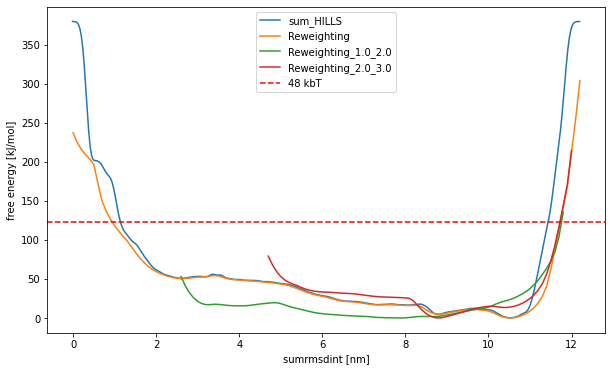

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel("sumrmsdint [nm]")
plt.ylabel("free energy [kJ/mol]")
plt.plot(data_b["sumrmsdint"],data_b["file.free"], label="sum_HILLS")
plt.plot(data_r["sumrmsdint"],data_r["ffrmsda"]-min(data_r["ffrmsda"]),label="Reweighting")
plt.plot(data_r1_2["sumrmsdint"],data_r1_2["ffrmsda"]-min(data_r1_2["ffrmsda"]),label="Reweighting_1.0_2.0")
plt.plot(data_r2_3["sumrmsdint"],data_r2_3["ffrmsda"]-min(data_r2_3["ffrmsda"]),label="Reweighting_2.0_3.0")
plt.axhline(y = 123.36, color = 'r', linestyle = 'dashed', label = "48 kbT")  
#plt.ylim([0, 20])
plt.legend()

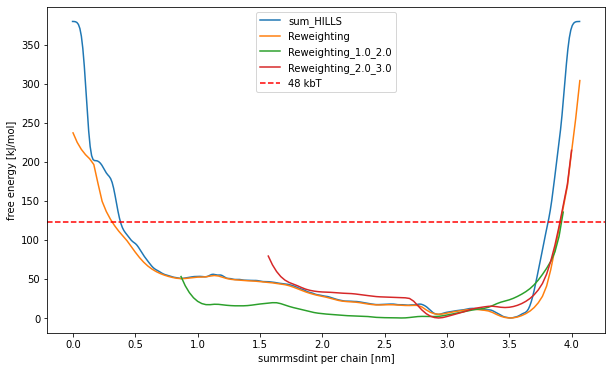

In [12]:
plt.figure(figsize=(10,6))
plt.xlabel("sumrmsdint per chain [nm]")
plt.ylabel("free energy [kJ/mol]")
plt.plot(data_b["sumrmsdint"]/3,data_b["file.free"], label="sum_HILLS")
plt.plot(data_r["sumrmsdint"]/3,data_r["ffrmsda"]-min(data_r["ffrmsda"]),label="Reweighting")
plt.plot(data_r1_2["sumrmsdint"]/3,data_r1_2["ffrmsda"]-min(data_r1_2["ffrmsda"]),label="Reweighting_1.0_2.0")
plt.plot(data_r2_3["sumrmsdint"]/3,data_r2_3["ffrmsda"]-min(data_r2_3["ffrmsda"]),label="Reweighting_2.0_3.0")
plt.axhline(y = 123.36, color = 'r', linestyle = 'dashed', label = "48 kbT")  
#plt.ylim([0, 20])
plt.legend()